<h1 align="center">Trabalho 2 - Circuito Booleano</h1>
<h3 align="center">Novembro, 2021</h3>

Inês Pires Presa - A90355  
Tiago dos Santos Silva Peixoto Carriço - A91695

In [ ]:
!pip install ortools

## Análise do Problema:

### Descrição

Pretende-se gerar um circuito booleano com um único *wire* de output, a partir do número $\,n\,$ de *wires* de *input* e de um parâmetro positivo $\,\gamma\ll 1\,$ como argumentos, com *gates* *or*, *and*, *xor* e *not*  em que o número de and's é  $\,\gamma\ast\,$ (número total de nodos).  
A partir do circuito gerado, tem-se em vista, usando Programação Inteira, encontrar valores para os "inputs" que sejam aceites pelo circuito.

## Gerar o circuito

Para gerar o grafo que descreve o circuito utilizamos a biblioteca NetworkX. Começamos por calcular o número de nodos do grafo a partir do número de *and*'s (gerado aleatoriamente). De seguida, adicionamos os *wires* do input ao grafo e criamos uma variável SCIP para cada um, dando-lhe o nome $x_i$ em que i é o número do nodo. Escolhemos os diferentes *gates* para além dos *and*'s que vão ser usados e, finalmente, fomos adicionando cada *gate* ligando a um número aleatório de *wires* de input e criando um novo *wire* para *output* do mesmo.

### Funções:

In [ ]:
import networkx as nx
from ortools.linear_solver import pywraplp
import random
import math

- `is_wire(grafo, n)` - verifica se um dado nodo é um *wire*

In [ ]:
def is_wire(grafo, n):
  return 'wire' in grafo.nodes[n]

- `wires_vazios(grafo)`- devolve uma lista com os *wires* que não têm arestas de saída e outra com os restantes.

In [ ]:
def wires_vazios(grafo):
  lista_vazios = []
  lista_nao_vazios = []
  for n in grafo:
    if is_wire(grafo, n):
      if grafo.out_degree(n) == 0:
        lista_vazios.append(n)
      else:
        lista_nao_vazios.append(n)
    
  return lista_vazios, lista_nao_vazios

- `ligar_wires(grafo, numero_de_inputs, lista_wires_vazios, lista_wires_nao_vazios, nodo)` - recebe o grafo, o número de *inputs* definidos para o gate, a lista de *wire*'s que têm de ser usados, a lista dos restantes *wire*'s e o número do nodo do *gate*; adiciona ao grafo as arestas $wire_{i}\rightarrow nodo$

In [ ]:
def ligar_wires(grafo, numero_de_inputs, lista_wires_vazios, lista_wires_nao_vazios, nodo):
  for wire in lista_wires_vazios:
    grafo.add_edge(wire, nodo)
    numero_de_inputs -= 1
  
  while numero_de_inputs > 0:
    i = random.randint(0, len(lista_wires_nao_vazios)-1)
    wire = lista_wires_nao_vazios.pop(i)
    grafo.add_edge(wire, nodo)
    numero_de_inputs -= 1

- `gera_grafo(N, gama, maxAnds, solver)` - gera o grafo que descreve o circuito

In [ ]:
def gera_grafo(N, gama, maxAnds, solver):
  grafo = nx.DiGraph()

  ands = random.randint(math.ceil(gama*(N+2)), maxAnds)
  numero_de_nodos = math.ceil(ands / gama)
  nodo = 0

  while nodo < N:
    grafo.add_node(nodo,val=solver.BoolVar("x_%i" % nodo), wire = 1)
    nodo += 1

  numero_de_gates = int((numero_de_nodos - 2*ands - N) / 2)
  gates = []

  while ands > 0:
    gates.append('and')
    ands -= 1

  while numero_de_gates > 0:
    x = random.randint(1,3)
    if x == 1:
      gates.append('or')
    elif x == 2:
      gates.append('not')
    else:
      gates.append('xor')
    numero_de_gates -= 1

  numero_de_wires = N
  while gates != []:
    gate = gates.pop(random.randint(0,len(gates)-1))
    grafo.add_node(nodo, val = gate)
    
    lista_wires_vazios, lista_wires_nao_vazios = wires_vazios(grafo)
    if gate != 'not':
      if all([x == 'not' for x in gates]):
        numero_de_inputs = random.randint(len(lista_wires_vazios),
                                          numero_de_wires)
      else:
        numero_de_inputs = random.randint(1, numero_de_wires)
        lista_wires_nao_vazios = lista_wires_nao_vazios + lista_wires_vazios
        lista_wires_vazios = []
    else:
      numero_de_inputs = 1
      if not all([x == 'not' for x in gates]):
        lista_wires_nao_vazios = lista_wires_nao_vazios + lista_wires_vazios
        lista_wires_vazios = []

    ligar_wires(grafo, numero_de_inputs, lista_wires_vazios,
                lista_wires_nao_vazios, nodo)
    nodo += 1
    grafo.add_node(nodo, val=solver.BoolVar("x_%i" % nodo), wire = 1)
    grafo.add_edge(nodo-1, nodo)
    numero_de_wires += 1
    nodo += 1

  return grafo

In [ ]:
s = pywraplp.Solver.CreateSolver('SCIP')
N = 3
gama = 0.1
maxAnds = math.ceil(gama*(N+2))*3
grafo = gera_grafo(N,gama, maxAnds, s)

pos = nx.nx_pydot.graphviz_layout(grafo)

nx.draw(grafo, pos , with_labels=True, node_size=400, 
        node_color=['yellow' if is_wire(grafo, n) else 'red' for n in grafo], 
        labels={n:(grafo.nodes[n]['val'] if not is_wire(grafo, n) else n) for n in grafo})

- Verificar o número de nodos, *and*'s e *wires*: 

In [ ]:
print("Número de nodos: " + str(len(grafo.nodes())))
soma = 0
wires = 0
outputs = 0
for n in grafo:
  if is_wire(grafo, n):
    wires += 1
  elif grafo.nodes[n]['val'] == 'and':
    soma += 1
print("Número de and's: " + str(soma))
print("Número de wires: " + str(wires))

## Ler o circuito

Para ler o circuito percorremos todos os nodos do grafo e no caso de ser um *gate* adicionamos ao solver a respetiva condição:

| Operador                            | Expansão em Aritmética Linear Inteira|
| ----------------------------------- | ------------------------------------ |
| $$y = \mathbf{neg}(x)$$             | $$y + x = 1$$      |
| $$y = \mathbf{or}(x_1,\cdots,x_n)$$ | $$y \leq \sum_i\,x_i\quad e \; x_i \leq y\;\forall_{i=1..n}$$        |
| $$y = \mathbf{and}(x_1,\cdots,x_n)$$| $$\sum_i x_i < y+n\;e\;x_i \geq y\;\forall_{i=1..n}$$        |
| $$y = \mathbf{xor}(x_1,\cdots,x_n)$$| $$y + 2y' = \sum_{i=1}^n\,x_i \; : \,0\leq y' \leq \lfloor n/2\rfloor$$       |


Neste caso, $y$ é o output do *gate* e $(x_1,\cdots,x_n)$ são os inputs do mesmo.


In [ ]:
def ler_circuito(grafo, solver):
  for n in grafo:
    if not is_wire(grafo, n):
      lista_wires = list(map(lambda x: x[0],grafo.in_edges(n)))
      wire_saida = list(grafo.out_edges(n))[0][1]
      if grafo.nodes[n]['val'] == 'or':
        solver.Add(sum([grafo.nodes[w]['val'] for w in lista_wires]) >= grafo.nodes[wire_saida]['val'])
        for x in lista_wires:
          solver.Add(grafo.nodes[x]['val'] <= grafo.nodes[wire_saida]['val'])
      elif grafo.nodes[n]['val'] == 'not':
        solver.Add(grafo.nodes[wire_saida]['val'] + grafo.nodes[lista_wires[0]]['val'] == 1)
      elif grafo.nodes[n]['val'] == 'xor':
        y = solver.IntVar(0,len(lista_wires)//2, "y_%i" % n)
        solver.Add(grafo.nodes[wire_saida]['val'] + 2*y == sum([grafo.nodes[w]['val'] for w in lista_wires]))
      else:
        solver.Add(sum([grafo.nodes[w]['val'] for w in lista_wires]) <= grafo.nodes[wire_saida]['val'] + len(lista_wires) - 1)
        for x in lista_wires:
          solver.Add(grafo.nodes[x]['val'] >= grafo.nodes[wire_saida]['val'])

## Resolver o circuito

Para resolver o circuito adicionamos ao solver a condição de que o *output* (*wire* com grau de saída 0) tem valor 1.  
De seguida, invocamos o *solver* para obter o valor de cada um dos *inputs* que constituem o vetor aceite pelo circuito.

In [ ]:
def resolver_circuito(grafo, solver, N):
  wire_output = -1
  for n in grafo:
    if grafo.out_degree(n) == 0:
      wire_output = n
      break

  solver.Add(grafo.nodes[wire_output]['val'] == 1)

  status = solver.Solve()
  if status == pywraplp.Solver.OPTIMAL:
    vetor_inputs = []
    for n in range(N):
      vetor_inputs.append( round(grafo.nodes[n]['val'].solution_value()) )
    return vetor_inputs
  return None

In [ ]:
ler_circuito(grafo, s)
lista = resolver_circuito(grafo, s, N)
print(lista)

## Determinar o vetor $ x' \neq x $

Para obter o vetor mais próximo do encontrado anteriormente que também é aceite pelo circuito adicionamos duas condições ao *solver*:

1. Pelo menos um *wire* de input deve ser diferente do obtido anteriormente
$$\sum_{i\in [1..N]}(input_{i} - vetor_{i})^2 \ge 1$$
1. O número de *wire* que são alterados é mínimo, ou seja, minimizar a expressão:
$$\sum_{i\in [1..N]}(input_{i} - vetor_{i})^2 $$

In [ ]:
def vetor_proximo(grafo, vetor, solver, N):
  solver.Add(sum([grafo.nodes[n]['val'] - 2*grafo.nodes[n]['val']*vetor[n] + vetor[n] for n in range(N)]) >= 1 )

  solver.Minimize(sum([grafo.nodes[n]['val'] - 2*grafo.nodes[n]['val']*vetor[n] + vetor[n] for n in range(N)]))

  status = solver.Solve()
  if status == pywraplp.Solver.OPTIMAL:
    vetor_inputs = []
    for n in range(N):
      vetor_inputs.append( round(grafo.nodes[n]['val'].solution_value()) )
    return vetor_inputs
  return None

In [ ]:
vetor_proximo = vetor_proximo(grafo, lista, s, N)
print(vetor_proximo)

##Exemplo 1
N = 40  
$\gamma$ = 0.01  

Grafo gerado:

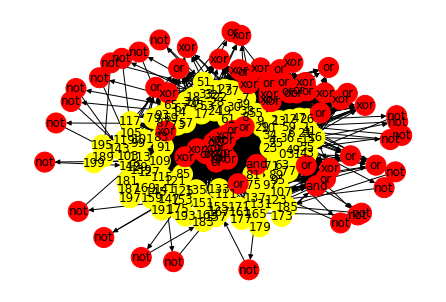

Número de nodos: 200  
Número de *and*'s: 2   
Número de *wires*: 120

Resultado 1: [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 0, 0, 0]

Resultado 2: [0, 1, 0, 1, 0, 1, 1, 0, 0, 0, 1, 1, 0, 1, 1, 0, 1, 0, 1, 1, 1, 0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 1, 0, 0, 0]

##Exemplo 2
N = 90 
$\gamma$ = 0.01  

Grafo gerado:

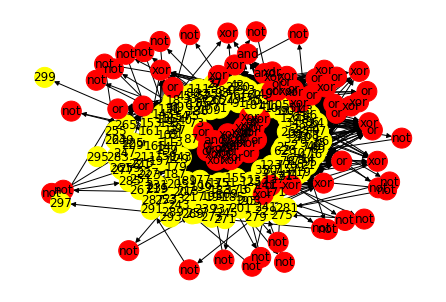

Número de nodos: 300  
Número de *and*'s: 3   
Número de *wires*: 195

Resultado 1: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]

Resultado 2: [1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 1, 1, 0, 1, 1, 1, 1, 0, 1, 1, 1, 1, 1, 1, 0, 1, 1]


##Exemplo 3
N = 4  
$\gamma$ = 0.003  

Grafo gerado:

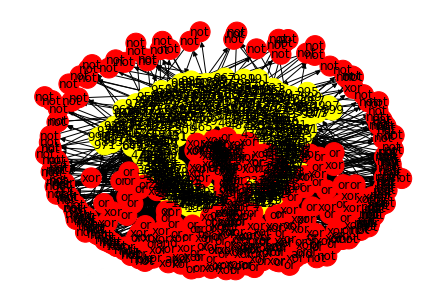

Número de nodos: 1000  
Número de *and*'s: 3   
Número de *wires*: 502

Resultado 1: [0, 1, 0, 0]

Resultado 2: [1, 1, 0, 0]

## Exemplo 4
N = 3  
$\gamma$ = 0.1

Grafo gerado: 

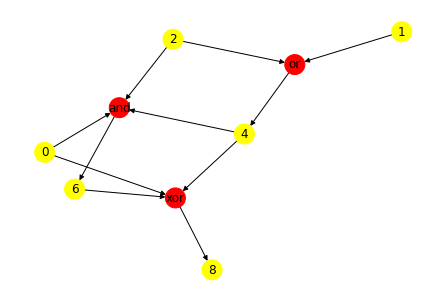

Número de nodos: 9  
Número de *and*'s: 1   
Número de *wires*: 6

Resultado 1: [1, 1, 1]

Resultado 2: [0, 1, 1]